In [1]:
import os, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch


from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from extract23 import extract_url_features, feature_names

In [2]:
tqdm_kwargs = dict(leave=False, dynamic_ncols=True)

RANDOM_STATE = 42
URLS_PER_MAIL_CAP = 5
POOL_STRATEGY = "max"

DATA_DIR = Path("0814Dataset")
DATASETS = [
    ("CEAS_08", "CEAS_08_emails_sorted.csv"),
    ("TREC_07", "TREC_07_emails_sorted.csv"),
    ("C08T07Spam", "merged_C08T07Spam_emails_sorted.csv"),
    ("New_Proportion", "new_proportion_dataset_sorted.csv"),
]
BODY_COL = "body"
#LABEL_COL = "label"


IGNORE_URLS_IN_BERT = True
URL_PLACEHOLDER = "[URL]"     

URL_REPLACE = re.compile(
    r"""(?ix)\b(?:(?:https?://)|(?:www\.))[^\s<>'"(){}\[\]]+|\b\w+://[^\s<>'"(){}\[\]]+""".strip()
)

def replace_urls_with_placeholder(text: str) -> str:
    # replace url to [URL]
    if not isinstance(text, str):
        return ""
    return URL_REPLACE.sub(URL_PLACEHOLDER, text.strip())

def text_embeddings(corpus):

    print("[Stage]: SBERT (all-MiniLM-L6-v2, 384D)")
    sb = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")
    #let [URL] become one of tokenizer
    added = sb.tokenizer.add_special_tokens({"additional_special_tokens": [URL_PLACEHOLDER]})
    if added > 0:
        sb[0].auto_model.resize_token_embeddings(len(sb.tokenizer), mean_resizing=False)
    url_token_id = sb.tokenizer.convert_tokens_to_ids(URL_PLACEHOLDER)

    # SBERT ignore URL 
    texts = list(corpus)
    if IGNORE_URLS_IN_BERT:
        texts = [replace_urls_with_placeholder(t) for t in texts]

    all_embeds = []
    for i in tqdm(range(0, len(texts), 64), desc="[SBERT] encoding", **tqdm_kwargs):
        batch = texts[i:i+64]

        # tokenizer get features
        features = sb.tokenize(batch)
        # put [URL] attention_mask set 0
        input_ids = features["input_ids"]
        attn = features["attention_mask"]
        mask_pos = (input_ids == url_token_id)
        attn[mask_pos] = 0
        features["attention_mask"] = attn

        with torch.no_grad():
            out = sb(features)
            emb = out["sentence_embedding"].cpu().numpy()

        all_embeds.append(emb)

    X = np.vstack(all_embeds).astype("float32")
    print(f"[Stage] finish: SBERT, shape={X.shape}")
    return X, "sbert-all-MiniLM-L6-v2"

# URL features
def urls_to_list_column(df: pd.DataFrame, body_col: str = "body") -> pd.Series:
    def _extract(text):
        if not isinstance(text, str): return []
        urls = URL_REPLACE.findall(text)
        cleaned = [u.strip('()[]<>"\' ,;.!?') for u in urls]
        if URLS_PER_MAIL_CAP > 0 and len(cleaned) > URLS_PER_MAIL_CAP:
            cleaned = cleaned[:URLS_PER_MAIL_CAP]
        return cleaned
    return df[body_col].apply(_extract)

def _pool_urls(urls):
    D = len(feature_names)
    if not urls: return np.zeros((D,), dtype=float)
    mat = extract_url_features(pd.Series(urls))
    agg = np.nanmax(mat, axis=0) if POOL_STRATEGY=="max" else np.nanmean(mat, axis=0)
    return agg.astype("float32")

def extract_url_features_multi_with_progress(url_lists: pd.Series) -> np.ndarray:
    rows = []
    for urls in tqdm(url_lists, desc="[URL] features", **tqdm_kwargs):
        rows.append(_pool_urls(urls or []))
    return np.vstack(rows).astype("float32")


In [3]:
# Classier
def _ensure_proba_or_score(clf, X):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    if hasattr(clf, "decision_function"):
        s = clf.decision_function(X)
        return s if s.ndim==1 else s[:,1]
    return clf.predict(X)

def make_calibrated_linear_svc():
    base = LinearSVC(dual=False, class_weight="balanced", random_state=RANDOM_STATE)
    return CalibratedClassifierCV(estimator=base, method="sigmoid", cv=5)

def train_models(X_tr, y_tr):
    models = {}
    svc = make_calibrated_linear_svc()
    svc_pipe = Pipeline([("scaler", StandardScaler()), ("clf", svc)])
    svc_pipe.fit(X_tr, y_tr); models["LinearSVC"] = svc_pipe

    rf = RandomForestClassifier(
        n_estimators=200, n_jobs=-1,
        random_state=RANDOM_STATE, class_weight="balanced_subsample"
    )
    rf.fit(X_tr, y_tr); models["RandomForest"] = rf

    mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(512,256),
                              activation="relu", max_iter=30,
                              learning_rate_init=1e-3,
                              random_state=RANDOM_STATE))
    ])
    mlp.fit(X_tr, y_tr); models["MLP"] = mlp
    return models

In [4]:
# Evaluation and charts
def evaluate_and_plot(name, clf, X_te, y_te, metrics_dict, curves_dict):
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="macro", zero_division=0)
    print(f"\n[{name}] Acc={acc:.4f} | F1={f1:.4f} | Prec={prec:.4f} | Rec={rec:.4f}")
    print(classification_report(y_te, y_pred, digits=4))

    metrics_dict[name] = dict(Acc=acc, F1=f1, Prec=prec, Rec=rec)

    # Confusion Matrix
    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC
    y_score = _ensure_proba_or_score(clf, X_te)
    fpr, tpr, _ = roc_curve(y_te, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"ROC - {name}"); plt.legend(); plt.show()

    # PR
    precs, recalls, _ = precision_recall_curve(y_te, y_score)
    plt.figure(figsize=(5,4))
    plt.plot(recalls, precs, label=f"{name}")
    plt.title(f"PR - {name}"); plt.legend(); plt.show()

    curves_dict[name] = dict(fpr=fpr, tpr=tpr, roc_auc=roc_auc, precs=precs, recalls=recalls)



========== Running CEAS_08 ==========
[CEAS_08] date range: 1980-01-04 05:39:00+00:00  →  2100-05-27 19:54:05+00:00


[CEAS_08] Progress:   0%|                                 | 0/5 [00:00<?, ?it/s]

[Stage]: SBERT (all-MiniLM-L6-v2, 384D)


[SBERT] encoding:   0%|                                 | 0/567 [00:00<?, ?it/s]

[Stage] finish: SBERT, shape=(36233, 384)


[URL] features:   0%|                                 | 0/36233 [00:00<?, ?it/s]

[FeatureFusion] text=384D + URL=23D → total=407D
[TimeSplit] train: 0 ~ 28985（28986），test: 28986 ~ 36232（7247）
[TimeSplit] cutoff date (first test sample): 2008-08-07 23:32:31+00:00

[LinearSVC] Acc=0.7900 | F1=0.7786 | Prec=0.8382 | Rec=0.7816
              precision    recall  f1-score   support

           0     0.7209    0.9749    0.8288      3780
           1     0.9555    0.5884    0.7283      3467

    accuracy                         0.7900      7247
   macro avg     0.8382    0.7816    0.7786      7247
weighted avg     0.8331    0.7900    0.7807      7247



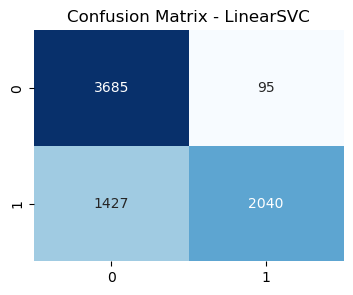

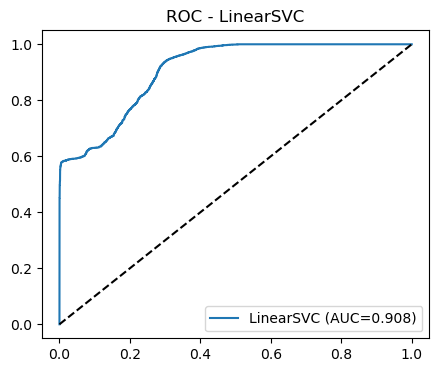

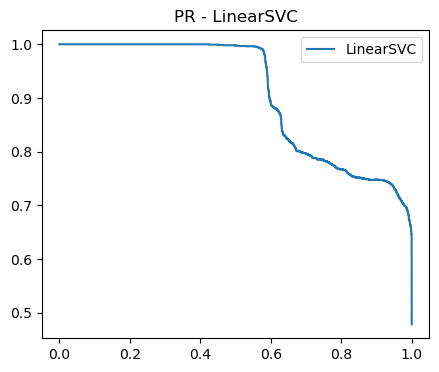


[RandomForest] Acc=0.7941 | F1=0.7818 | Prec=0.8501 | Rec=0.7853
              precision    recall  f1-score   support

           0     0.7205    0.9889    0.8336      3780
           1     0.9796    0.5818    0.7300      3467

    accuracy                         0.7941      7247
   macro avg     0.8501    0.7853    0.7818      7247
weighted avg     0.8445    0.7941    0.7841      7247



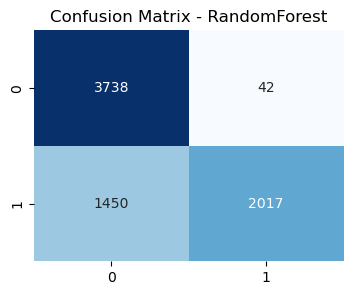

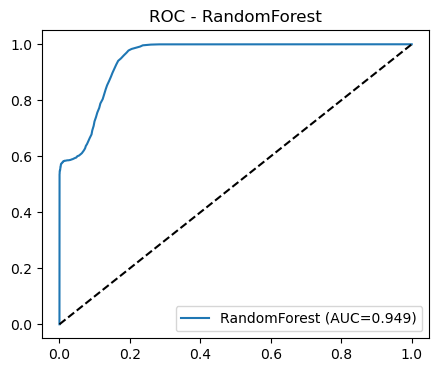

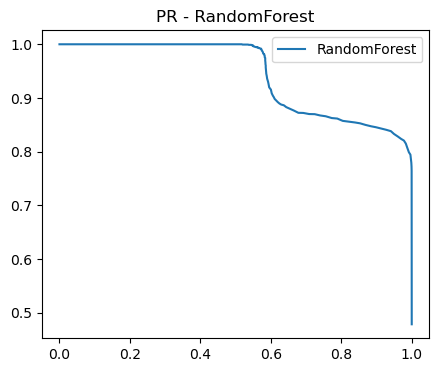


[MLP] Acc=0.8003 | F1=0.7884 | Prec=0.8576 | Rec=0.7916
              precision    recall  f1-score   support

           0     0.7249    0.9947    0.8386      3780
           1     0.9903    0.5884    0.7382      3467

    accuracy                         0.8003      7247
   macro avg     0.8576    0.7916    0.7884      7247
weighted avg     0.8519    0.8003    0.7906      7247



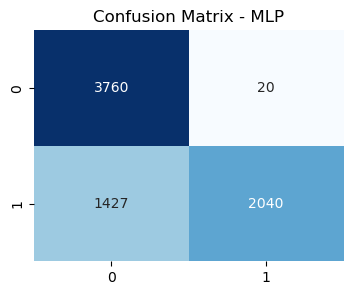

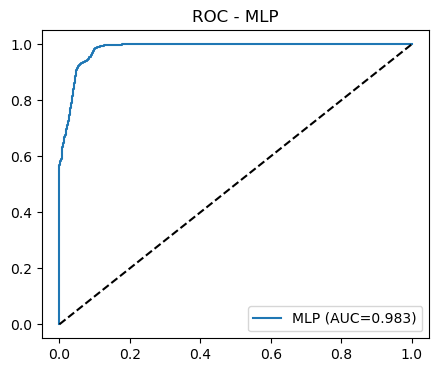

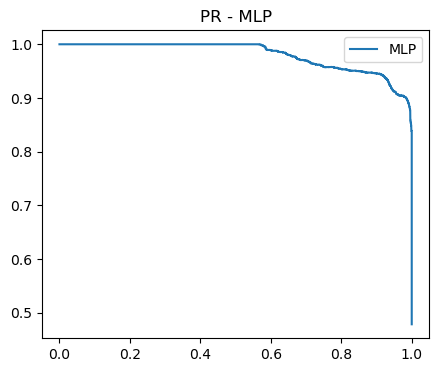

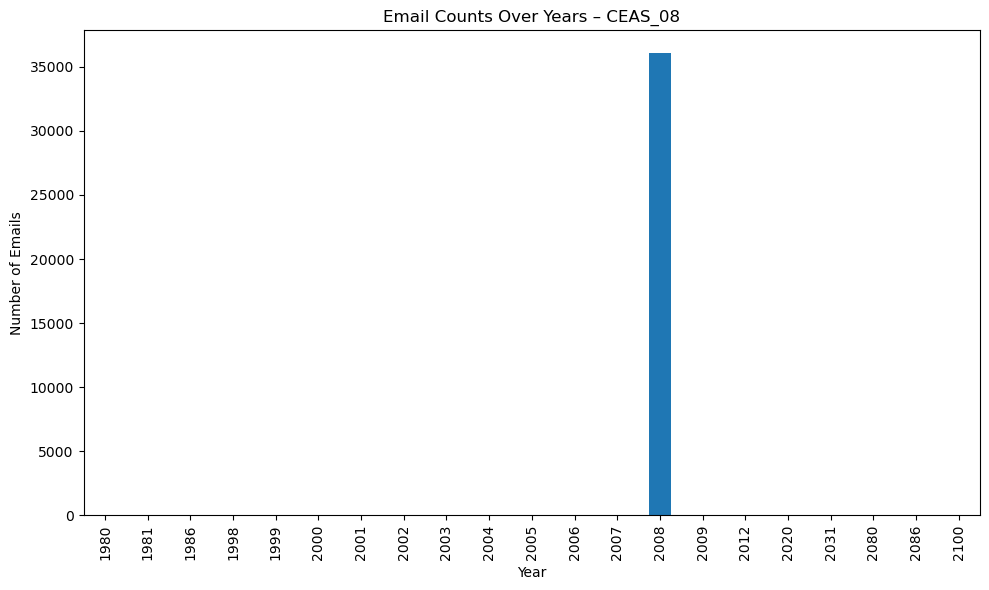


========== Running TREC_07 ==========
[TREC_07] date range: 1900-06-27 19:57:30+00:00  →  2102-03-16 15:16:56+00:00


[TREC_07] Progress:   0%|                                 | 0/5 [00:00<?, ?it/s]

[Stage]: SBERT (all-MiniLM-L6-v2, 384D)


[SBERT] encoding:   0%|                                 | 0/803 [00:00<?, ?it/s]

[Stage] finish: SBERT, shape=(51355, 384)


[URL] features:   0%|                                 | 0/51355 [00:00<?, ?it/s]

[FeatureFusion] text=384D + URL=23D → total=407D
[TimeSplit] train: 0 ~ 41083（41084），test: 41084 ~ 51354（10271）
[TimeSplit] cutoff date (first test sample): 2007-06-18 20:20:55+00:00

[LinearSVC] Acc=0.9738 | F1=0.9737 | Prec=0.9733 | Rec=0.9742
              precision    recall  f1-score   support

           0     0.9648    0.9789    0.9718      4735
           1     0.9817    0.9695    0.9756      5536

    accuracy                         0.9738     10271
   macro avg     0.9733    0.9742    0.9737     10271
weighted avg     0.9739    0.9738    0.9738     10271



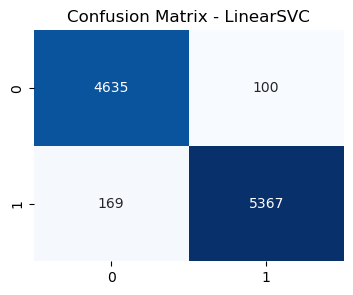

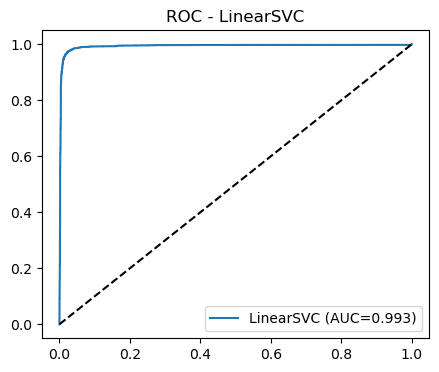

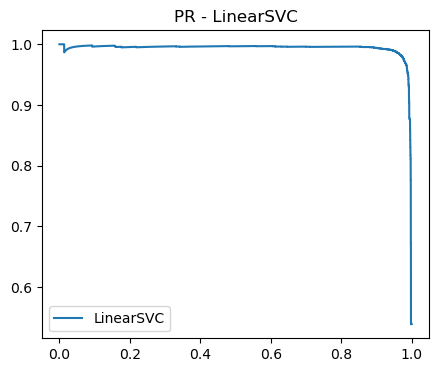


[RandomForest] Acc=0.9773 | F1=0.9772 | Prec=0.9775 | Rec=0.9768
              precision    recall  f1-score   support

           0     0.9800    0.9706    0.9753      4735
           1     0.9751    0.9830    0.9790      5536

    accuracy                         0.9773     10271
   macro avg     0.9775    0.9768    0.9772     10271
weighted avg     0.9773    0.9773    0.9773     10271



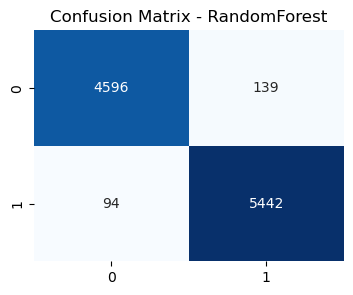

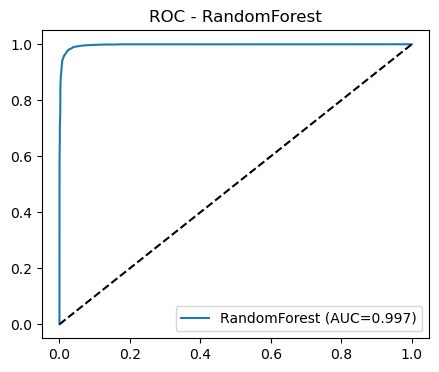

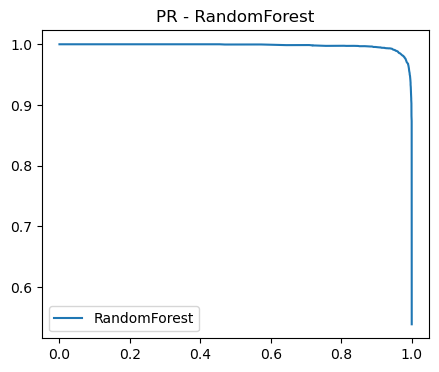


[MLP] Acc=0.9875 | F1=0.9875 | Prec=0.9874 | Rec=0.9876
              precision    recall  f1-score   support

           0     0.9853    0.9878    0.9865      4735
           1     0.9895    0.9874    0.9884      5536

    accuracy                         0.9875     10271
   macro avg     0.9874    0.9876    0.9875     10271
weighted avg     0.9875    0.9875    0.9875     10271



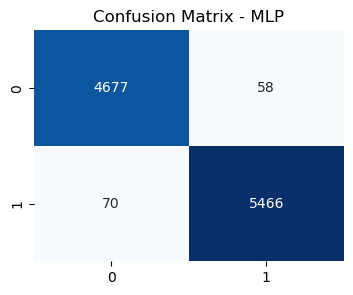

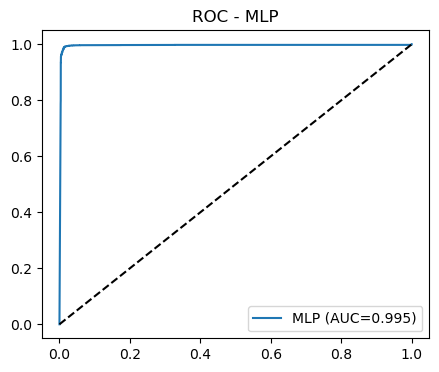

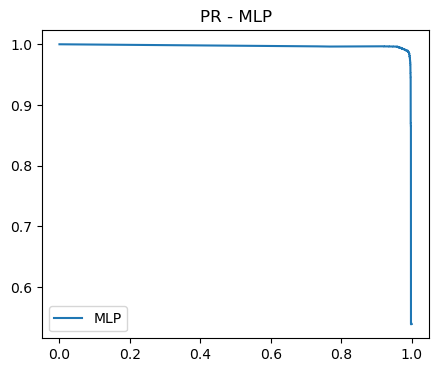

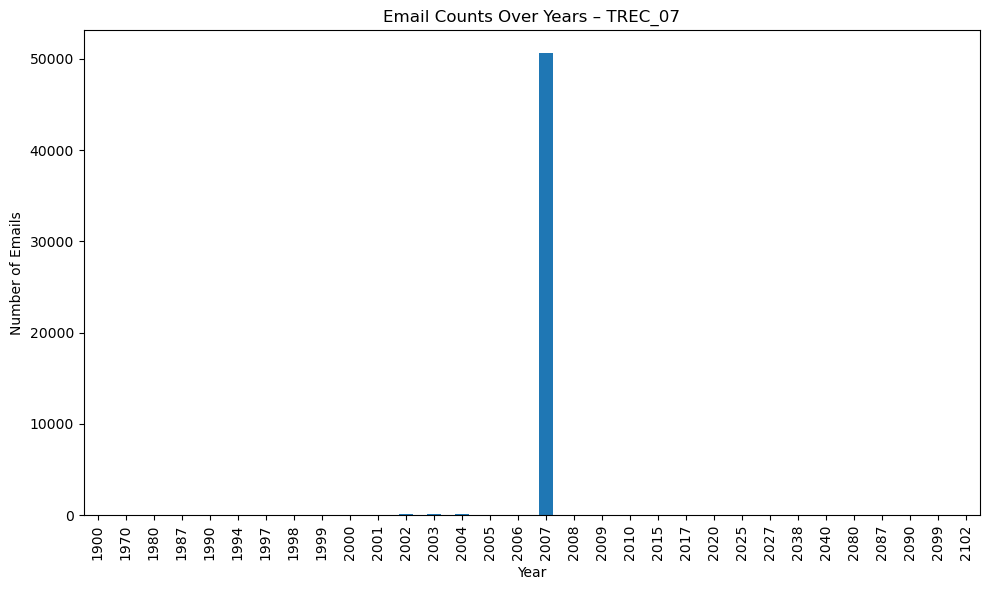


========== Running C08T07Spam ==========
[C08T07Spam] date range: 1900-06-27 19:57:30+00:00  →  2102-03-16 15:16:56+00:00


[C08T07Spam] Progress:   0%|                              | 0/5 [00:00<?, ?it/s]

[Stage]: SBERT (all-MiniLM-L6-v2, 384D)


[SBERT] encoding:   0%|                                | 0/1447 [00:00<?, ?it/s]

[Stage] finish: SBERT, shape=(92572, 384)


[URL] features:   0%|                                 | 0/92572 [00:00<?, ?it/s]

[FeatureFusion] text=384D + URL=23D → total=407D
[TimeSplit] train: 0 ~ 74056（74057），test: 74057 ~ 92571（18515）
[TimeSplit] cutoff date (first test sample): 2008-08-07 00:50:55+00:00

[LinearSVC] Acc=0.8895 | F1=0.8893 | Prec=0.8898 | Rec=0.8928
              precision    recall  f1-score   support

           0     0.8433    0.9305    0.8847      8440
           1     0.9362    0.8552    0.8939     10075

    accuracy                         0.8895     18515
   macro avg     0.8898    0.8928    0.8893     18515
weighted avg     0.8939    0.8895    0.8897     18515



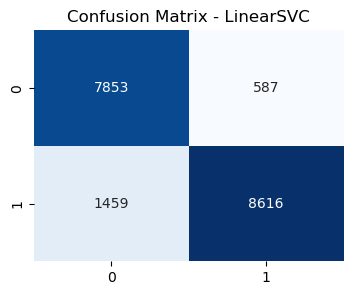

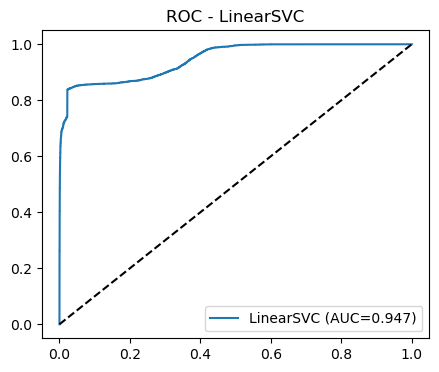

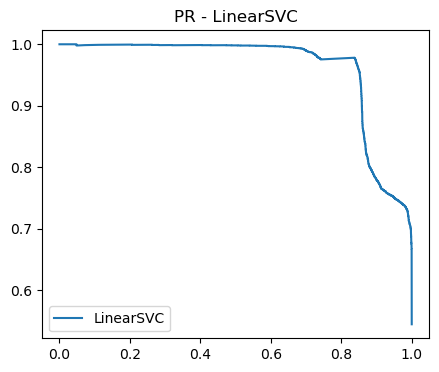


[RandomForest] Acc=0.8849 | F1=0.8847 | Prec=0.8847 | Rec=0.8877
              precision    recall  f1-score   support

           0     0.8425    0.9193    0.8793      8440
           1     0.9268    0.8561    0.8900     10075

    accuracy                         0.8849     18515
   macro avg     0.8847    0.8877    0.8847     18515
weighted avg     0.8884    0.8849    0.8851     18515



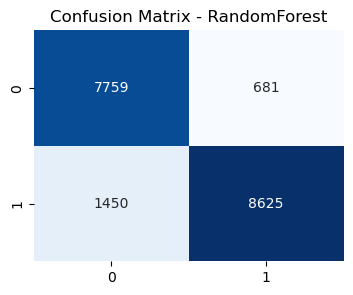

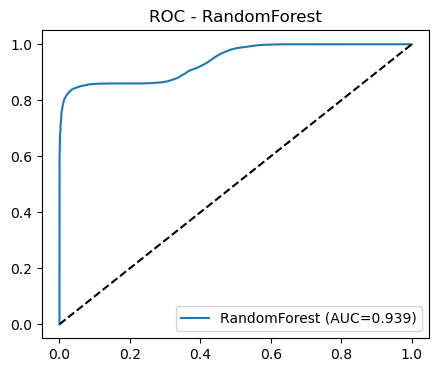

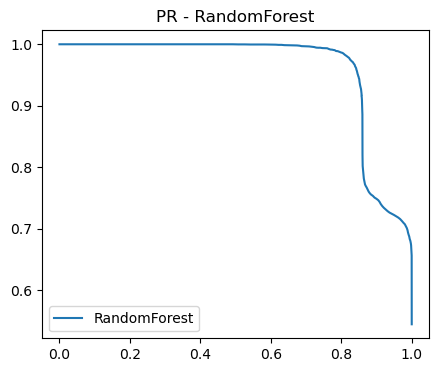


[MLP] Acc=0.9059 | F1=0.9059 | Prec=0.9082 | Rec=0.9108
              precision    recall  f1-score   support

           0     0.8485    0.9661    0.9035      8440
           1     0.9679    0.8555    0.9082     10075

    accuracy                         0.9059     18515
   macro avg     0.9082    0.9108    0.9059     18515
weighted avg     0.9135    0.9059    0.9061     18515



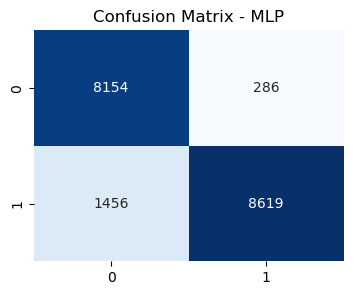

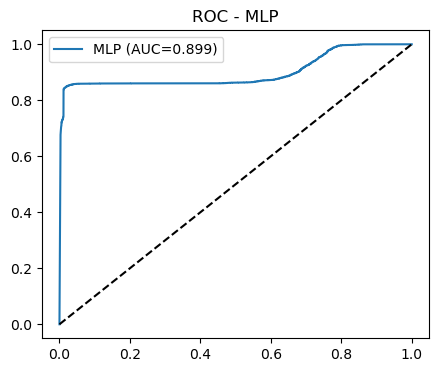

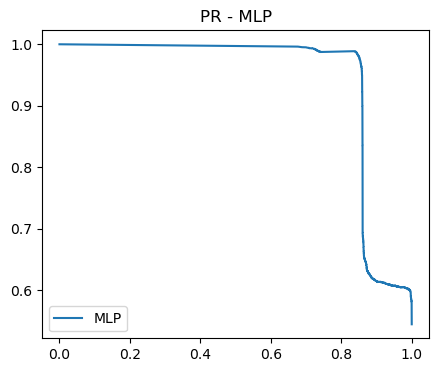

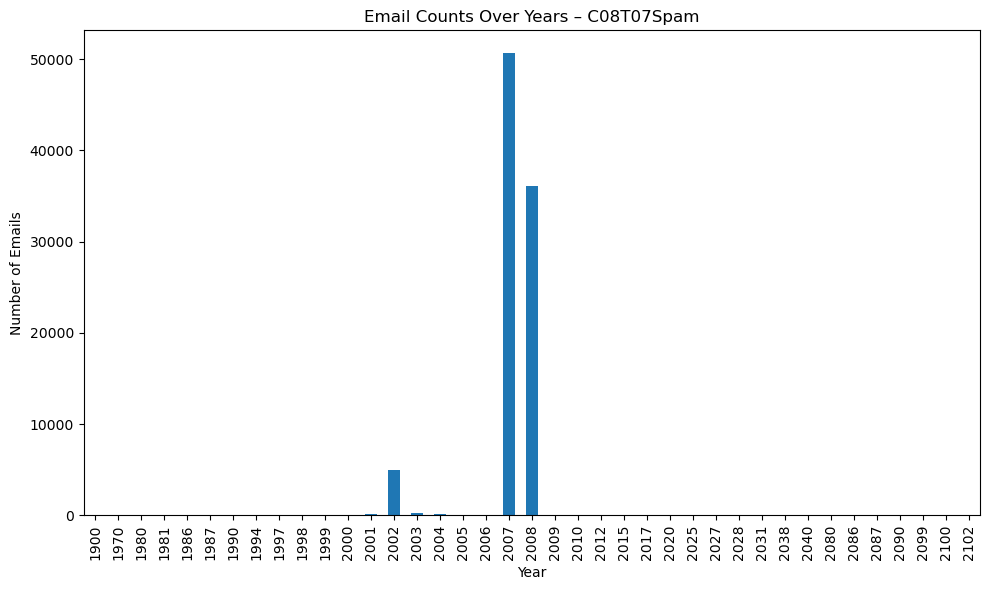


========== Running New_Proportion ==========
[New_Proportion] date range: 1970-06-07 03:39:30+00:00  →  2086-08-06 00:34:28+00:00


[New_Proportion] Progress:   0%|                          | 0/5 [00:00<?, ?it/s]

[Stage]: SBERT (all-MiniLM-L6-v2, 384D)


[SBERT] encoding:   0%|                                 | 0/773 [00:00<?, ?it/s]

[Stage] finish: SBERT, shape=(49451, 384)


[URL] features:   0%|                                 | 0/49451 [00:00<?, ?it/s]

[FeatureFusion] text=384D + URL=23D → total=407D
[TimeSplit] train: 0 ~ 39559（39560），test: 39560 ~ 49450（9891）
[TimeSplit] cutoff date (first test sample): 2008-08-06 22:59:37+00:00

[LinearSVC] Acc=0.9560 | F1=0.8780 | Prec=0.9001 | Rec=0.8589
              precision    recall  f1-score   support

           0     0.9690    0.9822    0.9756      8840
           1     0.8312    0.7355    0.7804      1051

    accuracy                         0.9560      9891
   macro avg     0.9001    0.8589    0.8780      9891
weighted avg     0.9543    0.9560    0.9548      9891



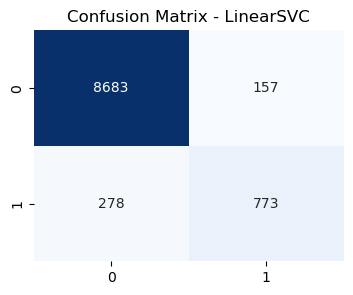

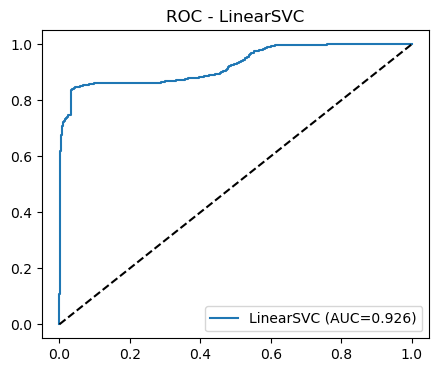

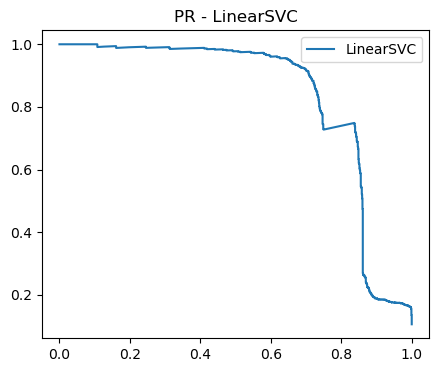


[RandomForest] Acc=0.9554 | F1=0.8557 | Prec=0.9732 | Rec=0.7919
              precision    recall  f1-score   support

           0     0.9529    0.9995    0.9757      8840
           1     0.9935    0.5842    0.7358      1051

    accuracy                         0.9554      9891
   macro avg     0.9732    0.7919    0.8557      9891
weighted avg     0.9572    0.9554    0.9502      9891



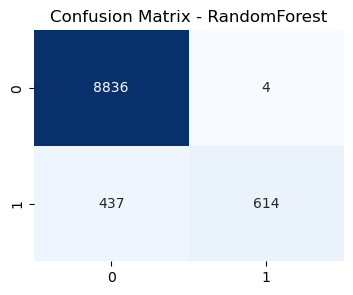

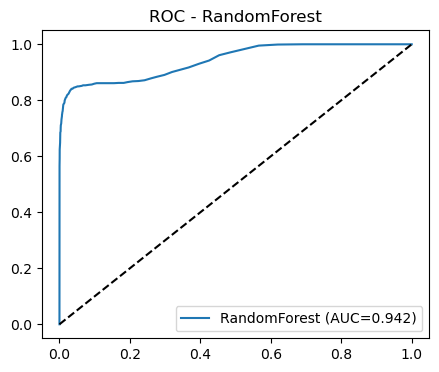

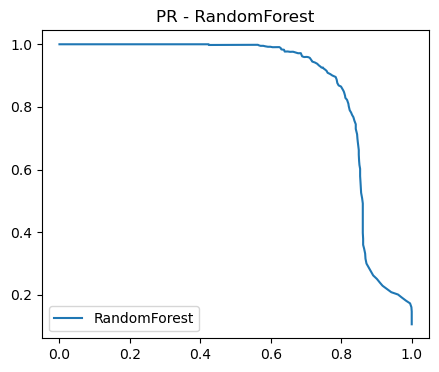


[MLP] Acc=0.9722 | F1=0.9244 | Prec=0.9393 | Rec=0.9107
              precision    recall  f1-score   support

           0     0.9803    0.9888    0.9845      8840
           1     0.8984    0.8325    0.8642      1051

    accuracy                         0.9722      9891
   macro avg     0.9393    0.9107    0.9244      9891
weighted avg     0.9716    0.9722    0.9717      9891



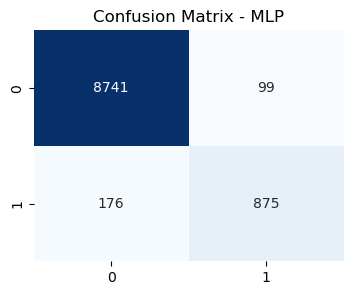

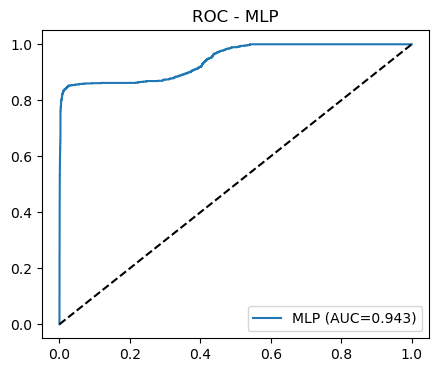

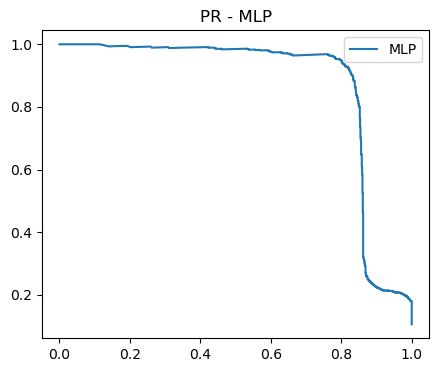

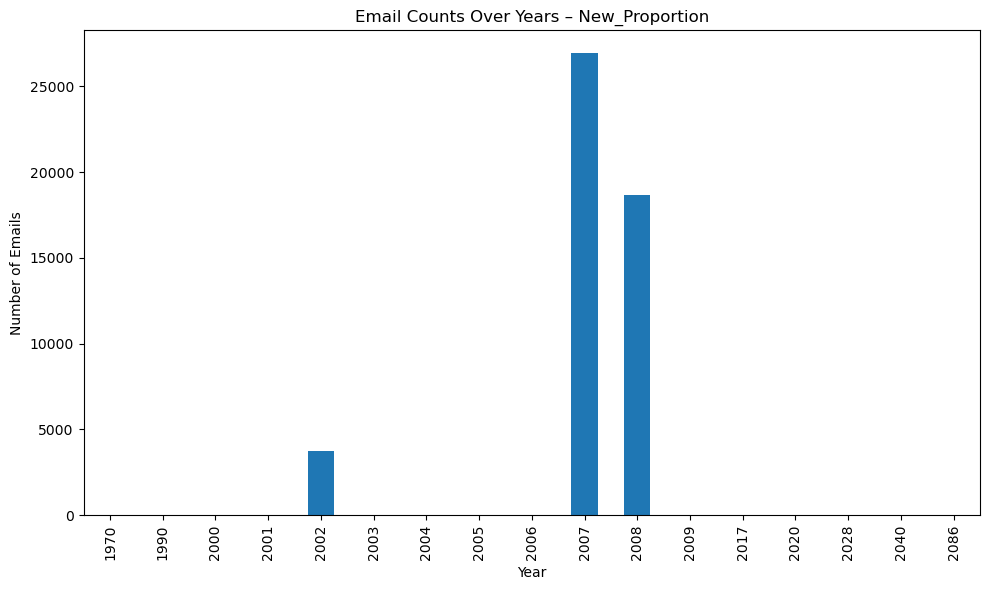


 performance comparison table
             CEAS_08                         TREC_07                          \
                 Acc      F1    Prec     Rec     Acc      F1    Prec     Rec   
LinearSVC     0.7900  0.7786  0.8382  0.7816  0.9738  0.9737  0.9733  0.9742   
MLP           0.8003  0.7884  0.8576  0.7916  0.9875  0.9875  0.9874  0.9876   
RandomForest  0.7941  0.7818  0.8501  0.7853  0.9773  0.9772  0.9775  0.9768   

             C08T07Spam                         New_Proportion          \
                    Acc      F1    Prec     Rec            Acc      F1   
LinearSVC        0.8895  0.8893  0.8898  0.8928         0.9560  0.8780   
MLP              0.9059  0.9059  0.9082  0.9108         0.9722  0.9244   
RandomForest     0.8849  0.8847  0.8847  0.8877         0.9554  0.8557   

                              
                Prec     Rec  
LinearSVC     0.9001  0.8589  
MLP           0.9393  0.9107  
RandomForest  0.9732  0.7919  


In [5]:
summary_results = {}

def run_one_dataset(csv_path: Path, ds_name: str):
    print("\n" + "="*10 + f" Running {ds_name} " + "="*10)
    df = pd.read_csv(csv_path)

    if "date" not in df.columns:
        raise ValueError(f"[{ds_name}] CSV not find 'date'，can't split by time")

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date", na_position="first").reset_index(drop=True)
    print(f"[{ds_name}] date range: {df['date'].min()}  →  {df['date'].max()}")

    steps = ["bodyFeatures", "URLFeatures", "FeatureFusion", "Trainning", "Evaluation"]
    with tqdm(total=len(steps), desc=f"[{ds_name}] Progress", **tqdm_kwargs) as pbar:

        X_text, _ = text_embeddings(df[BODY_COL].astype(str).fillna(""))
        pbar.update(1)

        df["url_list"] = urls_to_list_column(df, body_col=BODY_COL)
        X_url = extract_url_features_multi_with_progress(df["url_list"])
        pbar.update(1)

        X = np.hstack([X_text, X_url])
        y = df["label"].values.astype(int)
        print(f"[FeatureFusion] text={X_text.shape[1]}D + URL={X_url.shape[1]}D → total={X.shape[1]}D")
        pbar.update(1)

        n = len(df)
        split_idx = int(n * 0.8)
        split_idx = min(max(split_idx, 1), n - 1)

        X_tr, X_te = X[:split_idx], X[split_idx:]
        y_tr, y_te = y[:split_idx], y[split_idx:]

        cutoff_date = df.loc[split_idx, "date"] if "date" in df.columns else None
        print(f"[TimeSplit] train: 0 ~ {split_idx-1}（{len(y_tr)}），test: {split_idx} ~ {n-1}（{len(y_te)}）")
        if cutoff_date is not None:
            print(f"[TimeSplit] cutoff date (first test sample): {cutoff_date}")

        models = train_models(X_tr, y_tr)
        pbar.update(1)

        metrics_dict, curves_dict = {}, {}
        for mname, clf in models.items():
            evaluate_and_plot(mname, clf, X_te, y_te, metrics_dict, curves_dict)
            for metric, val in metrics_dict[mname].items():
                summary_results[(ds_name, mname, metric)] = val
        pbar.update(1)

        if "date" in df.columns:
            df["date"] = pd.to_datetime(df["date"], errors="coerce")
            
            yearly_counts = df.groupby(df["date"].dt.to_period("Y")).size()
        
            plt.figure(figsize=(10,6))
            yearly_counts.plot(kind="bar")
            plt.title(f"Email Counts Over Years – {ds_name}")
            plt.xlabel("Year")
            plt.ylabel("Number of Emails")
            plt.tight_layout()
            plt.show()

def main():
    for ds_name, fname in DATASETS:
        csv_path = DATA_DIR / fname
        if not csv_path.exists():
            print(f"[skip] {csv_path} not exist"); continue
        run_one_dataset(csv_path, ds_name)

    if summary_results:
        df_summary = pd.Series(summary_results).unstack(level=[0,2])
        print("\n performance comparison table")
        print(df_summary.round(4))
        df_summary.to_csv("results_summary1.86.csv")

if __name__ == "__main__":
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    warnings.filterwarnings("ignore", category=UserWarning)
    main()
